In [1]:
import pandas as pd
import numpy as np
import nltk
import spacy
import textstat
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

# # Download necessary NLTK data
#nltk.download('punkt_tab')

# # Load spaCy English model
# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [2]:
class DescriptionMetricsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # No fitting necessary
        return self

    def transform(self, X):
        # Ensure 'description' column exists
        if 'description' not in X.columns:
            raise ValueError("DataFrame must contain a 'description' column.")

        X_transformed = X.copy()
        X_transformed['description'] = X_transformed['description'].fillna('').str.lower()

        # Initialize a DataFrame to store the metrics
        metrics = pd.DataFrame(index=X_transformed.index)

        # Word count
        metrics['word_count'] = X_transformed['description'].apply(lambda x: len(x.split()))

        # Sentence count
        metrics['sentence_count'] = X_transformed['description'].apply(lambda x: len(nltk.sent_tokenize(x)))

        # Average sentence length
        metrics['avg_sentence_length'] = metrics.apply(
            lambda x: x['word_count'] / x['sentence_count'] if x['sentence_count'] > 0 else 0, axis=1)

        # Unique word count
        metrics['unique_word_count'] = X_transformed['description'].apply(lambda x: len(set(x.split())))

        # Vocabulary richness
        metrics['vocab_richness'] = metrics.apply(
            lambda x: x['unique_word_count'] / x['word_count'] if x['word_count'] > 0 else 0, axis=1)

        # Count descriptive words (adjectives and adverbs)
        def count_descriptive_words(text):
            doc = nlp(text)
            count = sum(1 for token in doc if token.pos_ in ['ADJ', 'ADV'])
            return count

        metrics['descriptive_word_count'] = X_transformed['description'].apply(count_descriptive_words)

        # Readability scores
        metrics['flesch_reading_ease'] = X_transformed['description'].apply(lambda x: textstat.flesch_reading_ease(x))

        metrics['smog_index'] = X_transformed['description'].apply(lambda x: textstat.smog_index(x))

        # Fill NaN values with 0
        metrics = metrics.fillna(0)

        return metrics

class DataFrameScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=None):
        self.scaler = scaler if scaler is not None else MinMaxScaler()
        self.columns = None
        self.index = None

    def fit(self, X, y=None):
        # Store columns and index
        self.columns = X.columns
        self.index = X.index
        # Fit the scaler
        self.scaler.fit(X, y)
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        # Return as DataFrame
        return pd.DataFrame(X_scaled, columns=self.columns, index=X.index)

class DetailnessScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, weights):
        self.weights = weights

    def fit(self, X, y=None):
        # No fitting necessary
        return self

    def transform(self, X):
        # Ensure all required metrics are in X
        missing_metrics = [metric for metric in self.weights.keys() if metric not in X.columns]
        if missing_metrics:
            raise ValueError(f"Metrics {missing_metrics} not found in the input DataFrame.")

        # Compute the detailness_score
        detailness_score = X.apply(
            lambda x: sum(x[metric] * self.weights[metric] for metric in self.weights.keys()), axis=1
        )

        # Add the detailness_score as a new column
        X_transformed = X.copy()
        X_transformed['detailness_score'] = detailness_score

        # Return the DataFrame with scaled metrics and the detailness_score
        return X_transformed


In [3]:
# Define the weights for detailness score calculation
weights = {
    'word_count': 3/16,
    'sentence_count': 1/16,
    'avg_sentence_length': 1/16,
    'unique_word_count': 1/8,
    'vocab_richness': 1/16,
    'descriptive_word_count': 1/8,
    'flesch_reading_ease': 2/8,
    'smog_index': 1/8
}

# Build the pipeline with DataFrameScaler
description_pipeline = Pipeline(steps=[
    ('metrics', DescriptionMetricsTransformer()),
    ('scaler', DataFrameScaler()),
    ('detailness_score', DetailnessScoreTransformer(weights=weights))
])

In [4]:
# Load the datasets
train_data = pd.read_csv('./Data/train.csv', parse_dates=['host_since', 'first_review', 'last_review'])
test_data = pd.read_csv('./Data/test.csv', parse_dates=['host_since', 'first_review', 'last_review'])

# Fit the pipeline on the training data
train_detailness_score = description_pipeline.fit_transform(train_data)
# Transform the test data
test_detailness_score = description_pipeline.transform(test_data)

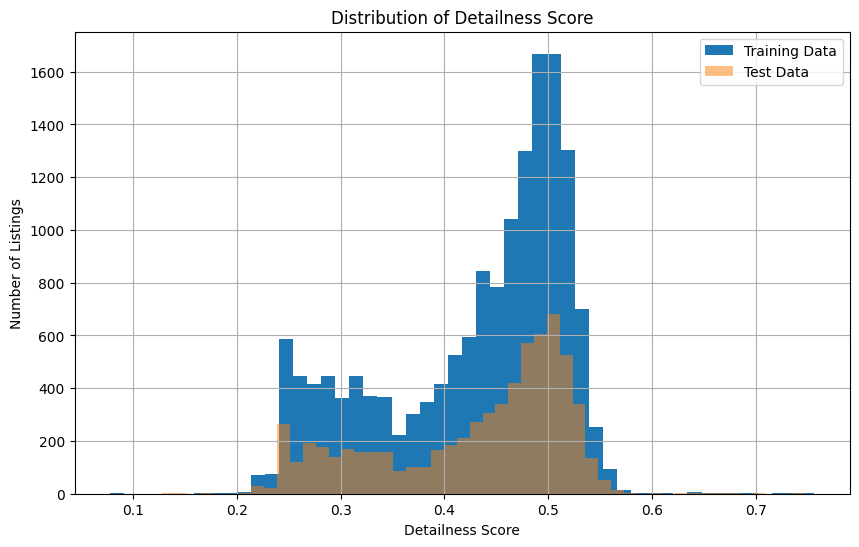

In [7]:
plt.figure(figsize=(10, 6))
train_detailness_score['detailness_score'].hist(bins=50, label='Training Data')
test_detailness_score['detailness_score'].hist(bins=50, alpha=0.5, label='Test Data')
plt.title('Distribution of Detailness Score')
plt.xlabel('Detailness Score')
plt.ylabel('Number of Listings')
plt.legend()
plt.show()

In [6]:
# save the word_count, sentence_count, descriptive_word_count, flesch_reading_ease, detailness_score
interested_columns = ['word_count', 'sentence_count', 'descriptive_word_count', 'flesch_reading_ease', 'detailness_score']

# train_detailness_score[interested_columns].to_csv('./Data/train_detailness_score.csv', index=False)
# test_detailness_score[interested_columns].to_csv('./Data/test_detailness_score.csv', index=False)